# SVM

what's left is test, train and validation for this SVM

In [59]:
pip install scikit-survival

In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [61]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

In [62]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [63]:
# rank ratio = 0
# As a regression problem: the model learns to directly predict the (log) survival time.
estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)

In [64]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Status"], y["Survival_in_days"], prediction)
    return result[0]

In [85]:
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2)}

# 5 repetitions of 5-fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, n_jobs=1, refit=False, cv=cv)

In [86]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x_train, y_train)

In [87]:
print("Best parameters:", gcv.best_params_)
print("Best C-index:", round(gcv.best_score_, 3))

Best parameters: {'alpha': 0.000244140625}
Best C-index: 0.29


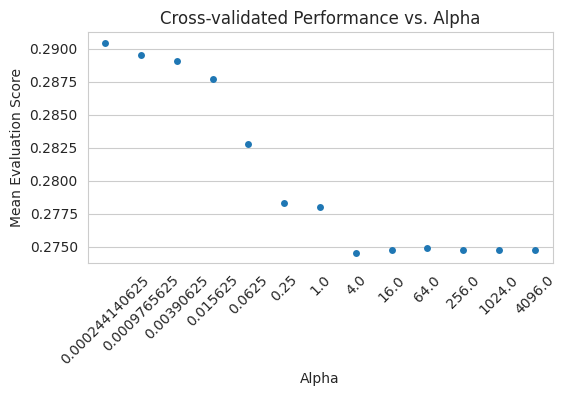

In [88]:
def plot_performance(gcv):
    n_splits = gcv.cv.get_n_splits()
    cv_results = pd.DataFrame(gcv.cv_results_)
    cv_results = cv_results.rename(columns=lambda x: x.replace("param_", ""))

    plt.figure(figsize=(6, 3))
    sns.stripplot(x="alpha", y="mean_test_score", data=cv_results, jitter=True, dodge=True)
    plt.title("Cross-validated Performance vs. Alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Mean Evaluation Score")
    plt.xticks(rotation=45)
    plt.show()

plot_performance(gcv)

In [89]:
estimator.set_params(**gcv.best_params_)
estimator.fit(x_train, y_train)

FastSurvivalSVM(alpha=0.000244140625, max_iter=1000, optimizer='avltree',
                random_state=0, rank_ratio=0.0, tol=1e-05)

In [98]:
test_pred = estimator.predict(x_test)
#print(np.round(test_pred, 3))
#print(y_test)

# Evaluate the model on the test set
test_cindex = concordance_index_censored(
    y_test["Status"],
    y_test["Survival_in_days"],
    -test_pred)           # flip sign to obtain risk scores
print("Concordance index on test set:", round(test_cindex[0], 3))


Concordance index on test set: 0.67


In [99]:
# reference estimator (regression) and result

ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(x_train, y_train)

cindex = concordance_index_censored(
    y_test["Status"],
    y_test["Survival_in_days"],
    -ref_estimator.predict(x_test),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

0.687


In [92]:
pred = ref_estimator.predict(x_test.iloc[:2])
print(np.round(pred, 3))

[ 3.643 35.007]
